# Background Removal using Mask R-CNN in PyTorch - Part 1: Core Implementation

This notebook demonstrates how to use Mask R-CNN to replace image backgrounds with black. The implementation is based on PyTorch and the Torchvision library.

## Dataset Overview
- Total number of images: 4,431
- Number of categories: 413
- Date range: 2025-02-17
- Image formats: JPEG, MPO
- Average dimensions: 1197x1308 pixels
- Average file size: 265.03 KB

## Data Quality Issues
- Missing values: 5,416 total across all columns
- Duplicate files: 0
- Date inconsistencies: 0
- Size outliers: 45
- Dimension outliers: 16

## 1. Setup and Import Libraries

In [1]:
# Install required packages if not already installed
!pip install torch torchvision matplotlib opencv-python tqdm

  Using cached torch-2.6.0-cp312-none-macosx_11_0_arm64.whl.metadata (28 kB)
  Using cached torchvision-0.21.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.1 kB)
  Using cached filelock-3.17.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached MarkupSafe-3.0.2-cp312-cp312-macosx_11_0_arm64.whl.metadata (4.0 kB)
Using cached torch-2.6.0-cp312-none-macosx_11_0_arm64.whl (66.5 MB)
Using cached sympy-1.13.1-py3-none-any.whl (6.2 MB)
Using cached torchvision-0.21.0-cp312-cp312-macosx_11_0_arm64.whl (1.8 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 3.0 MB/s eta 0:00:0000:0100:01
Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)
Using cached filelock-3.17.0-py3-none-any.whl (16 kB)
Using cached networkx-

In [29]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights
from PIL import Image
from torchvision import transforms

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 2. Load Mask R-CNN Model

In [30]:
# Load pre-trained Mask R-CNN model
weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
model = maskrcnn_resnet50_fpn(weights=weights)
model.to(device)
model.eval()

# Get COCO class names
COCO_INSTANCE_CATEGORY_NAMES = weights.meta["categories"]
print(f"Model loaded with {len(COCO_INSTANCE_CATEGORY_NAMES)} classes")

Model loaded with 91 classes


## 3. Image Preprocessing and Prediction Functions

In [31]:
def load_image(img_path):
    """Load an image and convert to RGB"""
    try:
        img = Image.open(img_path).convert("RGB")
        return img
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
        return None

def preprocess_image(img):
    """Preprocess image for the model"""
    # Define transforms
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    
    # Apply transforms
    img_tensor = transform(img)
    return img_tensor

def get_prediction(img_tensor, threshold=0.5):
    """Get model prediction"""
    with torch.no_grad():
        prediction = model([img_tensor.to(device)])
        
    return prediction[0]

## 4. Background Removal Function

In [32]:
def remove_background(img_path, confidence_threshold=0.7, save_path=None):
    """Remove background from image using Mask R-CNN"""
    # Load and preprocess image
    img = load_image(img_path)
    if img is None:
        return None, None
        
    img_tensor = preprocess_image(img)
    
    # Get predictions
    prediction = get_prediction(img_tensor)
    
    # Convert PIL image to numpy array for processing
    img_np = np.array(img)
    
    # Create a blank mask for the combined objects
    height, width = img_np.shape[:2]
    combined_mask = np.zeros((height, width), dtype=np.uint8)
    
    # Extract masks based on confidence score
    masks = prediction['masks']
    scores = prediction['scores']
    
    # Use a threshold to filter out low-confidence predictions
    high_confidence_masks = masks[scores > confidence_threshold]
    
    if len(high_confidence_masks) == 0:
        print(f"No objects detected with confidence threshold {confidence_threshold}")
        return img_np, combined_mask
    
    # Combine all high-confidence masks
    for mask_tensor in high_confidence_masks:
        mask = mask_tensor[0].cpu().numpy() > 0.5  # Convert to binary mask
        mask = mask.astype(np.uint8) * 255
        combined_mask = cv2.bitwise_or(combined_mask, mask)
    
    # Create a 3-channel mask for bitwise operations
    mask_3ch = cv2.merge([combined_mask, combined_mask, combined_mask])
    
    # Apply mask to keep foreground and make background black
    result = cv2.bitwise_and(img_np, mask_3ch)
    
    # Save result if path is provided
    if save_path:
        cv2.imwrite(save_path, cv2.cvtColor(result, cv2.COLOR_RGB2BGR))
    
    return result, combined_mask

## 5. Visualize Results

In [33]:
def visualize_results(original_img, processed_img, mask):
    """Visualize original image, mask, and processed image"""
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(original_img)
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title('Segmentation Mask')
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.title('Black Background Result')
    plt.imshow(processed_img)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

## 6. Process a Single Image

Let's test our implementation on a single image

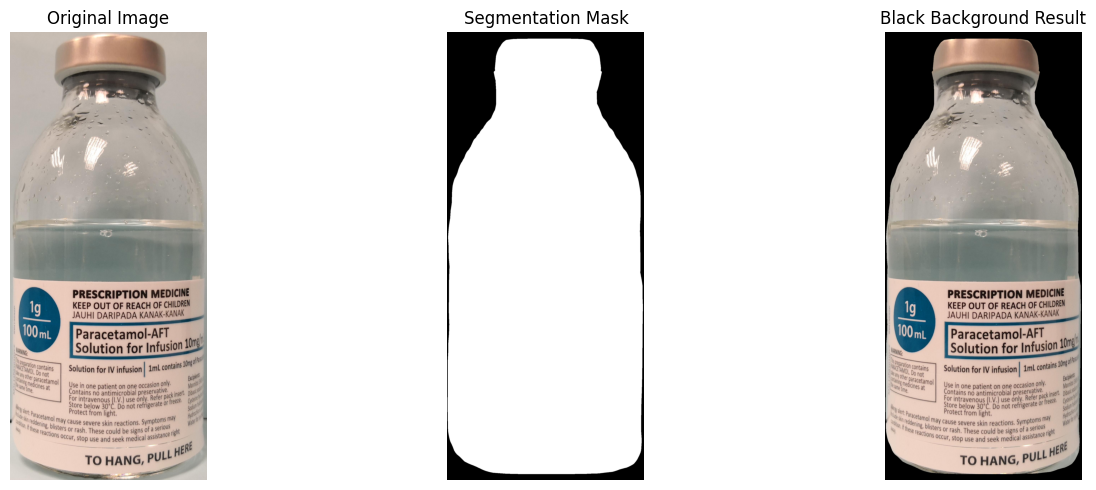

In [35]:
# Replace with your image path
sample_img_path = "../data/Parenterals/Paracetamol/Paracetamol (AFT Pharma - Front) Infusion 1g in 100ml (S.M. Farma, Italy) [31Jan2019]_0.jpg" 
# Check if the file exists
if os.path.exists(sample_img_path):
    # Load original image
    original_img = np.array(load_image(sample_img_path))
    
    # Process image
    processed_img, mask = remove_background(sample_img_path, confidence_threshold=0.3)
    
    # Visualize results
    visualize_results(original_img, processed_img, mask)
else:
    print(f"Image not found at {sample_img_path}. Please provide a valid image path.")

## 7. Advanced Post-Processing (Optional)

The basic Mask R-CNN segmentation might have imperfections at object boundaries. We can use GrabCut to refine the masks for better results.

In [17]:
def refine_mask_grabcut(img, mask, iterations=5):
    """Refine mask using GrabCut algorithm"""
    # Create a mask for GrabCut
    # 0: background, 1: foreground, 2: probable background, 3: probable foreground
    grabcut_mask = np.zeros(mask.shape, dtype=np.uint8)
    
    # Set mask values
    grabcut_mask[mask == 0] = 0  # Set definite background
    grabcut_mask[mask > 0] = 1    # Set definite foreground
    
    # Create background and foreground models
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    
    # Apply GrabCut
    rect = (0, 0, img.shape[1], img.shape[0])  # Full image rectangle
    cv2.grabCut(img, grabcut_mask, rect, bgdModel, fgdModel, iterations, cv2.GC_INIT_WITH_MASK)
    
    # Create mask where foreground and probable foreground pixels are 1
    refined_mask = np.where((grabcut_mask == 1) | (grabcut_mask == 3), 255, 0).astype('uint8')
    
    return refined_mask

In [18]:
def apply_refined_mask(img_path, confidence_threshold=0.7, use_grabcut=True, save_path=None):
    """Process image with optional refinement"""
    # Load and preprocess image
    img = load_image(img_path)
    if img is None:
        return None, None
        
    img_np = np.array(img)
    
    # Get basic mask
    processed_img, mask = remove_background(img_path, confidence_threshold)
    
    if use_grabcut and np.any(mask > 0):  # Only apply GrabCut if there's a mask
        # Refine mask with GrabCut
        refined_mask = refine_mask_grabcut(img_np, mask)
        
        # Create 3-channel mask
        mask_3ch = cv2.merge([refined_mask, refined_mask, refined_mask])
        
        # Apply refined mask
        refined_result = cv2.bitwise_and(img_np, mask_3ch)
        
        # Save result if path is provided
        if save_path:
            cv2.imwrite(save_path, cv2.cvtColor(refined_result, cv2.COLOR_RGB2BGR))
        
        return refined_result, refined_mask
    else:
        return processed_img, mask

In [19]:
def enhance_with_cap_detection(img_path, confidence_threshold=0.7, save_path=None):
    """
    Enhanced background removal with explicit cap detection
    """
    # Load and preprocess image
    img = load_image(img_path)
    if img is None:
        return None, None
        
    # Convert PIL image to numpy array for processing
    img_np = np.array(img)
    
    # Get standard mask using your existing method
    result, mask = remove_background(img_path, confidence_threshold)
    
    # Find the contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        # Get the largest contour (main bottle)
        main_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(main_contour)
        
        # Define cap region above the detected object
        cap_height = int(h * 0.15)  # Assume cap is about 15% of bottle height
        cap_region_y = max(0, y - cap_height)  # Look above the detected region
        
        # Create an extended mask including the cap region
        extended_mask = mask.copy()
        
        # Fill in the region above the bottle (where the cap likely is)
        extended_mask[cap_region_y:y, x:x+w] = 255
        
        # Create a 3-channel mask for bitwise operations
        mask_3ch = cv2.merge([extended_mask, extended_mask, extended_mask])
        
        # Apply mask to keep foreground and make background black
        enhanced_result = cv2.bitwise_and(img_np, mask_3ch)
        
        # Save result if path is provided
        if save_path:
            cv2.imwrite(save_path, cv2.cvtColor(enhanced_result, cv2.COLOR_RGB2BGR))
        
        return enhanced_result, extended_mask
    
    return result, mask

In [22]:
def compare_with_cap_enhancement(img_path, confidence_threshold=0.7):
    """Compare standard, GrabCut, and cap-enhanced background removal"""
    if not os.path.exists(img_path):
        print(f"Image not found at {img_path}")
        return
    
    # Load original image
    original_img = np.array(load_image(img_path))
    
    # Basic processing
    basic_img, basic_mask = remove_background(img_path, confidence_threshold)
    
    # GrabCut processing
    grabcut_img, grabcut_mask = apply_refined_mask(img_path, confidence_threshold, use_grabcut=True)
    
    # Cap-enhanced processing
    enhanced_img, enhanced_mask = enhance_with_cap_detection(img_path, confidence_threshold)
    
    # Visualize comparison
    plt.figure(figsize=(15, 10))
    
    # Original
    plt.subplot(2, 2, 1)
    plt.title('Original Image')
    plt.imshow(original_img)
    plt.axis('off')
    
    # Basic result
    plt.subplot(2, 2, 2)
    plt.title('Basic Background Removal')
    plt.imshow(basic_img)
    plt.axis('off')
    
    # GrabCut result
    plt.subplot(2, 2, 3)
    plt.title('Refined (GrabCut)')
    plt.imshow(grabcut_img)
    plt.axis('off')
    
    # Cap-enhanced result
    plt.subplot(2, 2, 4)
    plt.title('Cap-Enhanced Result')
    plt.imshow(enhanced_img)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

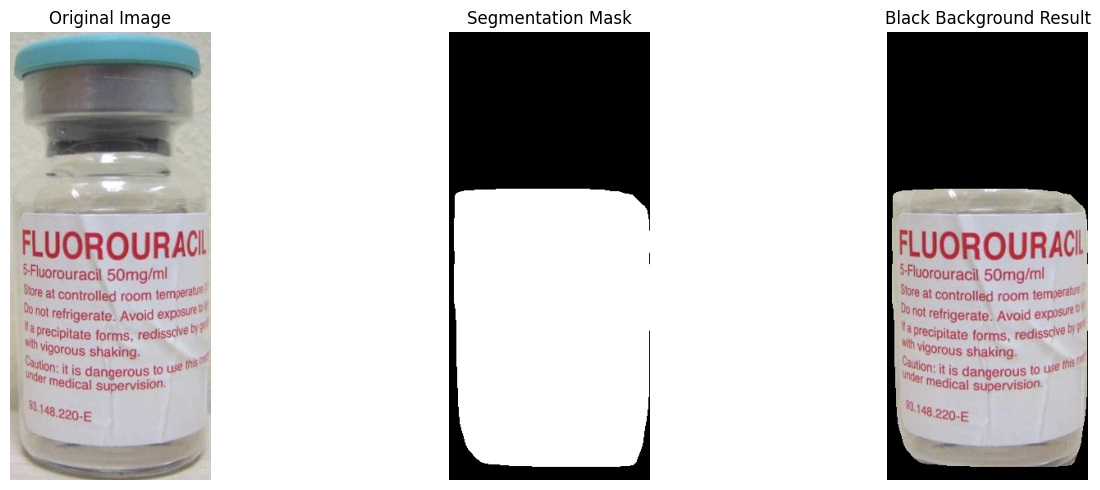

In [21]:
# Test advanced processing on the same image if it exists
if os.path.exists(sample_img_path):
    # Load original image
    original_img = np.array(load_image(sample_img_path))
    
    # Process image with refinement
    refined_img, refined_mask = apply_refined_mask(sample_img_path, confidence_threshold=0.7, use_grabcut=True)
    
    # Visualize results
    visualize_results(original_img, refined_img, refined_mask)
else:
    print(f"Image not found at {sample_img_path}. Please provide a valid image path.")

## 8. Comparing Results: Basic vs. Refined

Let's compare the results of basic Mask R-CNN segmentation with the refined GrabCut version

In [12]:
def compare_results(img_path, confidence_threshold=0.7):
    """Compare basic and refined background removal"""
    if not os.path.exists(img_path):
        print(f"Image not found at {img_path}")
        return
    
    # Load original image
    original_img = np.array(load_image(img_path))
    
    # Basic processing
    basic_img, basic_mask = remove_background(img_path, confidence_threshold)
    
    # Refined processing
    refined_img, refined_mask = apply_refined_mask(img_path, confidence_threshold, use_grabcut=True)
    
    # Visualize comparison
    plt.figure(figsize=(15, 10))
    
    # Original
    plt.subplot(2, 2, 1)
    plt.title('Original Image')
    plt.imshow(original_img)
    plt.axis('off')
    
    # Basic mask
    plt.subplot(2, 2, 2)
    plt.title('Basic Mask R-CNN Mask')
    plt.imshow(basic_mask, cmap='gray')
    plt.axis('off')
    
    # Basic result
    plt.subplot(2, 2, 3)
    plt.title('Basic Background Removal')
    plt.imshow(basic_img)
    plt.axis('off')
    
    # Refined result
    plt.subplot(2, 2, 4)
    plt.title('Refined Background Removal (GrabCut)')
    plt.imshow(refined_img)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

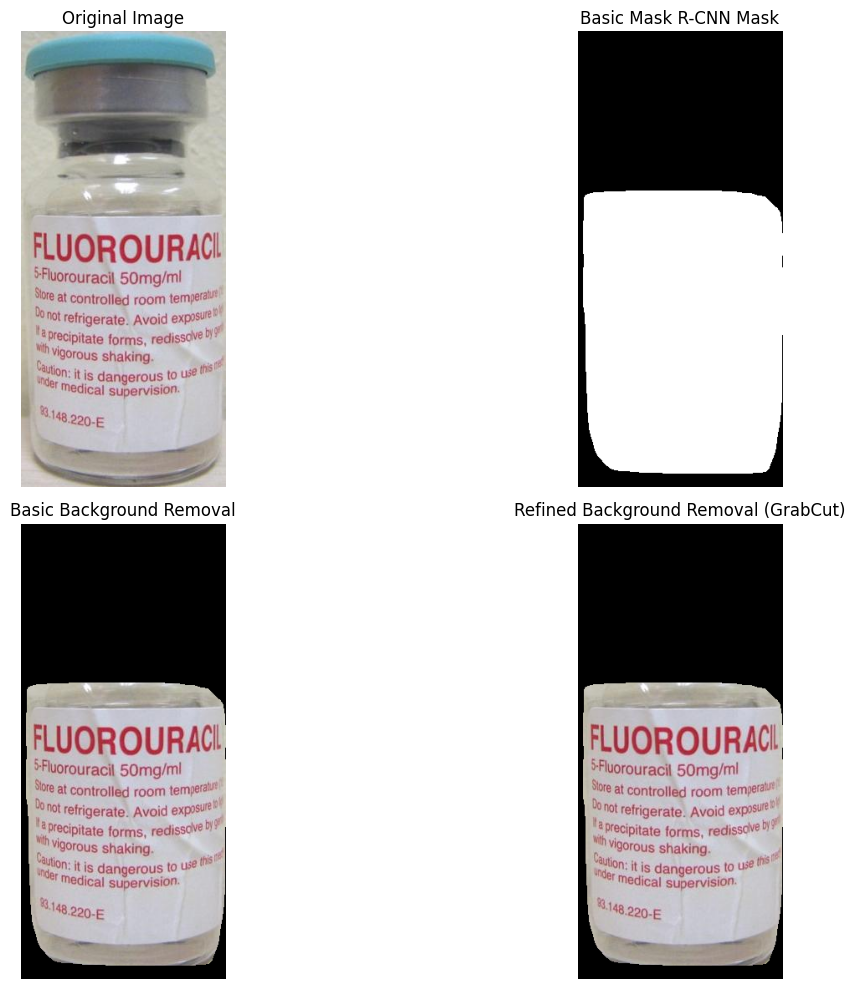

In [13]:
# Compare results if the sample image exists
if os.path.exists(sample_img_path):
    compare_results(sample_img_path, confidence_threshold=0.7)
else:
    print(f"Image not found at {sample_img_path}. Please provide a valid image path.")

## Next Steps: Architecture Modifications

- Use a model with higher resolution feature maps
- Consider using instance segmentation with multiple classes (bottle body and cap as separate classes)
- Implement boundary refinement modules to better capture object boundaries

In [27]:
def enhance_with_cap_detection(img_path, confidence_threshold=0.7, save_path=None):
    """
    Enhanced background removal with explicit cap detection (Approach 1)
    """
    # Load and preprocess image
    img = load_image(img_path)
    if img is None:
        return None, None
        
    # Convert PIL image to numpy array for processing
    img_np = np.array(img)
    
    # Get standard mask using your existing method
    result, mask = remove_background(img_path, confidence_threshold)
    
    # Find the contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        # Get the largest contour (main bottle)
        main_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(main_contour)
        
        # Define cap region above the detected object
        cap_height = int(h * 0.15)  # Assume cap is about 15% of bottle height
        cap_region_y = max(0, y - cap_height)  # Look above the detected region
        
        # Create an extended mask including the cap region
        extended_mask = mask.copy()
        
        # Fill in the region above the bottle (where the cap likely is)
        extended_mask[cap_region_y:y, x:x+w] = 255
        
        # Create a 3-channel mask for bitwise operations
        mask_3ch = cv2.merge([extended_mask, extended_mask, extended_mask])
        
        # Apply mask to keep foreground and make background black
        enhanced_result = cv2.bitwise_and(img_np, mask_3ch)
        
        # Save result if path is provided
        if save_path:
            cv2.imwrite(save_path, cv2.cvtColor(enhanced_result, cv2.COLOR_RGB2BGR))
        
        return enhanced_result, extended_mask
    
    return result, mask

def detect_and_include_cap(img_path, confidence_threshold=0.7, save_path=None):
    """
    Detect and include the bottle cap using color segmentation (Approach 2)
    """
    # Load and preprocess image
    img = load_image(img_path)
    if img is None:
        return None, None
        
    # Convert PIL image to numpy array for processing
    img_np = np.array(img)
    
    # Get standard mask using your existing method
    result, bottle_mask = remove_background(img_path, confidence_threshold)
    
    # Convert image to HSV for better color segmentation
    img_hsv = cv2.cvtColor(img_np, cv2.COLOR_RGB2HSV)
    
    # Define HSV range for light blue cap
    lower_blue = np.array([90, 50, 50])
    upper_blue = np.array([130, 255, 255])
    
    # Create color mask for the cap
    cap_mask = cv2.inRange(img_hsv, lower_blue, upper_blue)
    
    # Combine bottle mask and cap mask
    combined_mask = cv2.bitwise_or(bottle_mask, cap_mask)
    
    # Apply morphological closing to fill gaps between bottle and cap
    kernel = np.ones((5, 5), np.uint8)
    combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel)
    
    # Create a 3-channel mask for bitwise operations
    mask_3ch = cv2.merge([combined_mask, combined_mask, combined_mask])
    
    # Apply mask to keep foreground and make background black
    enhanced_result = cv2.bitwise_and(img_np, mask_3ch)
    
    # Save result if path is provided
    if save_path:
        cv2.imwrite(save_path, cv2.cvtColor(enhanced_result, cv2.COLOR_RGB2BGR))
    
    return enhanced_result, combined_mask

def boundary_expansion_solution(img_path, confidence_threshold=0.7, save_path=None):
    """
    Use boundary expansion to include caps in segmentation (Approach 3)
    """
    # Load and preprocess image
    img = load_image(img_path)
    if img is None:
        return None, None
        
    # Convert PIL image to numpy array for processing
    img_np = np.array(img)
    
    # Get standard mask using your existing method
    result, mask = remove_background(img_path, confidence_threshold)
    
    # Apply morphological dilation focused on the top region of detected objects
    height, width = mask.shape
    
    # Find contours to locate the objects
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create a top-focused dilation mask
    top_mask = np.zeros_like(mask)
    
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        # Focus on the top 20% of each object
        top_region_height = int(h * 0.2)
        top_region = mask[max(0, y-top_region_height):y+top_region_height, x:x+w]
        
        # Only process if the region is valid
        if top_region.size > 0:
            # Create a larger kernel for top expansion
            kernel = np.ones((15, 15), np.uint8)
            dilated_top = cv2.dilate(top_region, kernel, iterations=1)
            
            # Place the dilated top back
            top_mask[max(0, y-top_region_height):y+top_region_height, x:x+w] = dilated_top
    
    # Combine original mask with top-expanded mask
    enhanced_mask = cv2.bitwise_or(mask, top_mask)
    
    # Create a 3-channel mask for bitwise operations
    mask_3ch = cv2.merge([enhanced_mask, enhanced_mask, enhanced_mask])
    
    # Apply mask to keep foreground and make background black
    enhanced_result = cv2.bitwise_and(img_np, mask_3ch)
    
    # Save result if path is provided
    if save_path:
        cv2.imwrite(save_path, cv2.cvtColor(enhanced_result, cv2.COLOR_RGB2BGR))
    
    return enhanced_result, enhanced_mask

def compare_all_approaches(img_path, confidence_threshold=0.7):
    """Compare all approaches for fixing the bottle cap segmentation"""
    if not os.path.exists(img_path):
        print(f"Image not found at {img_path}")
        return
    
    # Load original image
    original_img = np.array(load_image(img_path))
    
    # Basic Mask R-CNN processing
    basic_img, basic_mask = remove_background(img_path, confidence_threshold)
    
    # Approach 1: Region extension
    approach1_img, approach1_mask = enhance_with_cap_detection(img_path, confidence_threshold)
    
    # Approach 2: Color-based segmentation
    approach2_img, approach2_mask = detect_and_include_cap(img_path, confidence_threshold)
    
    # Approach 3: Boundary expansion
    approach3_img, approach3_mask = boundary_expansion_solution(img_path, confidence_threshold)
    
    # Visualize comparison
    plt.figure(figsize=(20, 15))
    
    # Original
    plt.subplot(3, 3, 1)
    plt.title('Original Image')
    plt.imshow(original_img)
    plt.axis('off')
    
    # Basic Mask R-CNN
    plt.subplot(3, 3, 2)
    plt.title('Basic Mask R-CNN Result')
    plt.imshow(basic_img)
    plt.axis('off')
    
    # Basic Mask
    plt.subplot(3, 3, 3)
    plt.title('Basic Mask R-CNN Mask')
    plt.imshow(basic_mask, cmap='gray')
    plt.axis('off')
    
    # Approach 1: Region Extension
    plt.subplot(3, 3, 4)
    plt.title('Approach 1: Region Extension')
    plt.imshow(approach1_img)
    plt.axis('off')
    
    # Approach 1 Mask
    plt.subplot(3, 3, 5)
    plt.title('Approach 1: Region Extension Mask')
    plt.imshow(approach1_mask, cmap='gray')
    plt.axis('off')
    
    # Approach 2: Color-based
    plt.subplot(3, 3, 6)
    plt.title('Approach 2: Color-based')
    plt.imshow(approach2_img)
    plt.axis('off')
    
    # Approach 2 Mask
    plt.subplot(3, 3, 7)
    plt.title('Approach 2: Color-based Mask')
    plt.imshow(approach2_mask, cmap='gray')
    plt.axis('off')
    
    # Approach 3: Boundary Expansion
    plt.subplot(3, 3, 8)
    plt.title('Approach 3: Boundary Expansion')
    plt.imshow(approach3_img)
    plt.axis('off')
    
    # Approach 3 Mask
    plt.subplot(3, 3, 9)
    plt.title('Approach 3: Boundary Expansion Mask')
    plt.imshow(approach3_mask, cmap='gray')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

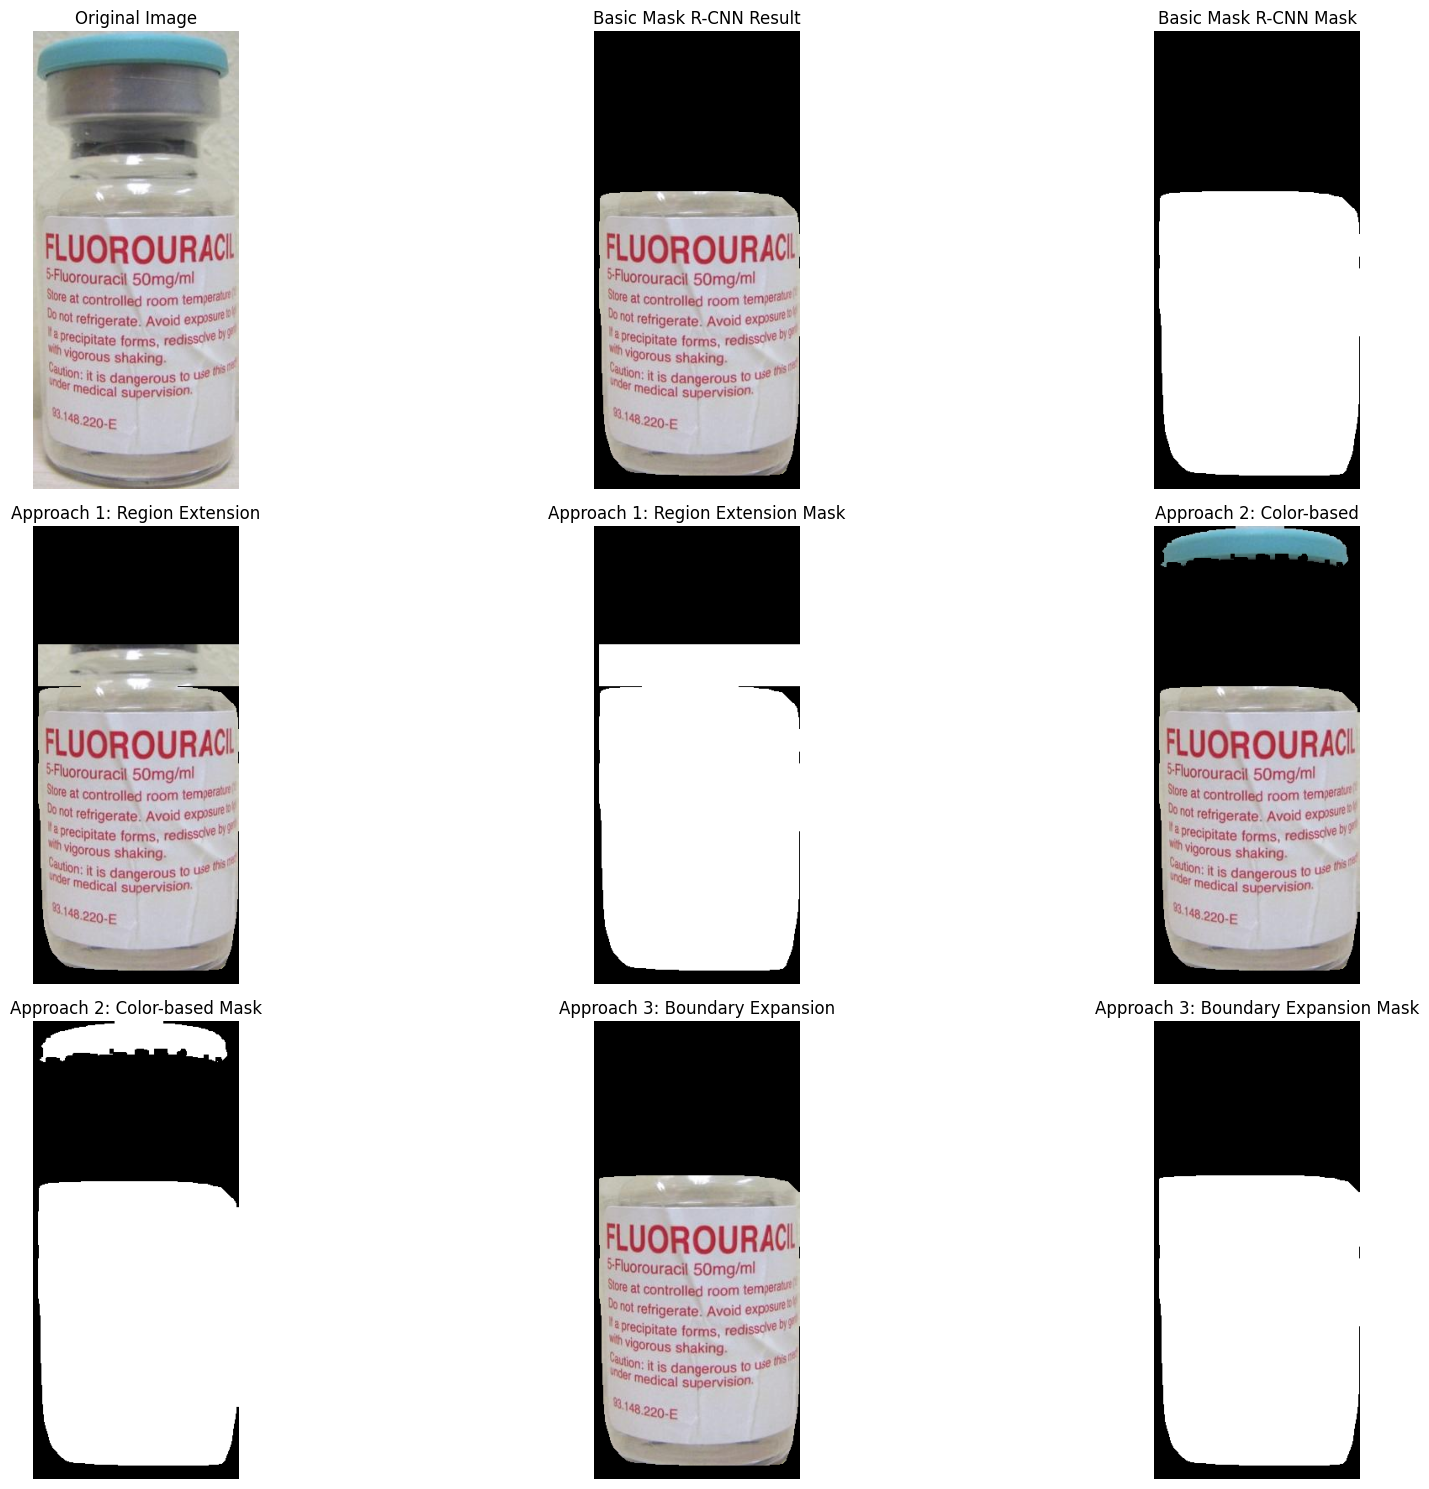

In [28]:
# Compare all approaches if the sample image exists
if os.path.exists(sample_img_path):
    compare_all_approaches(sample_img_path, confidence_threshold=0.7)
else:
    print(f"Image not found at {sample_img_path}. Please provide a valid image path.")

## 9. Conclusion and Next Steps

In this notebook, we've implemented basic and refined background removal using Mask R-CNN and GrabCut algorithms. The key components include:

1. Loading a pre-trained Mask R-CNN model
2. Processing images to detect objects and generate segmentation masks
3. Converting masks to binary format for background removal
4. Applying GrabCut refinement for improved edge quality
5. Visualizing and comparing the results

For batch processing and handling dataset quality issues, please refer to Part 2 of this notebook series.